In [46]:
import config
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [100]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [44]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [14]:
df = pd.read_csv('LoanStats_securev1_2019Q1.csv', header=1)
df.drop(df.tail(2).index,inplace=True)

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,129,130,131,134,135,136,139,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
# final pick
df1 = df[['id','annual_inc','loan_amnt','purpose','application_type','grade','emp_length','tot_hi_cred_lim','home_ownership','addr_state','fico_range_low','dti']]

# clean id to numeric
df1['id'] = pd.to_numeric(df1['id'])

# clean emp_length
df1 = df1.replace(to_replace=["< 1 year", "10+ years"], value=["0", "10"])
df1['emp_length'] = df1['emp_length'].str.replace('years','')
df1['emp_length'] = df1['emp_length'].str.replace('year','')
df1['emp_length'] = pd.to_numeric(df1['emp_length'])

# add more than 50k annual income column
def annual_inc_calculate(row):
    if row['annual_inc'] <= 50000:
        val = 0
    else:
        val = 1
    return val
df1['more_than_50k'] = df.apply(annual_inc_calculate, axis=1)

# limit dti
high_dti = df1[df1['dti'] > 100].index
df1.drop(high_dti, inplace=True)

# limit tot_hi_cred_lim
high_tot_hi_cred_lim = df1[df1['tot_hi_cred_lim'] > 1000000].index
df1.drop(high_tot_hi_cred_lim, inplace=True)

#show df
df1 = df1[['id','annual_inc','more_than_50k','purpose','application_type','grade','home_ownership','addr_state','loan_amnt','emp_length','tot_hi_cred_lim','fico_range_low','dti']]
df1

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,annual_inc,more_than_50k,purpose,application_type,grade,home_ownership,addr_state,loan_amnt,emp_length,tot_hi_cred_lim,fico_range_low,dti
0,149328059,68000.0,1,debt_consolidation,Individual,A,MORTGAGE,PA,13500.0,8.0,224894.0,750.0,15.74
1,149420408,110000.0,1,major_purchase,Individual,D,RENT,NY,20000.0,10.0,256497.0,675.0,23.44
2,149453166,27840.0,0,other,Individual,B,RENT,TX,1600.0,1.0,46994.0,685.0,15.99
3,149491641,28000.0,0,debt_consolidation,Individual,C,RENT,NY,6400.0,0.0,22700.0,700.0,8.62
4,149513578,130000.0,1,small_business,Joint App,A,MORTGAGE,LA,25000.0,0.0,348856.0,695.0,23.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115670,144957684,48000.0,0,home_improvement,Individual,C,MORTGAGE,FL,5000.0,NaN,88613.0,735.0,8.28
115671,143835299,96000.0,1,debt_consolidation,Individual,A,MORTGAGE,CT,6000.0,0.0,33500.0,740.0,0.31
115672,145177297,32000.0,0,debt_consolidation,Individual,C,MORTGAGE,CA,16000.0,10.0,34200.0,685.0,20.89
115673,145190854,72000.0,1,debt_consolidation,Individual,B,MORTGAGE,AZ,16000.0,5.0,251486.0,660.0,7.02


In [16]:
df1 = df1.dropna()

In [17]:
scale = MinMaxScaler()
df1[['loan_amnt','emp_length','tot_hi_cred_lim','fico_range_low','dti']] = scale.fit_transform(df1[['loan_amnt','emp_length','tot_hi_cred_lim','fico_range_low','dti']])

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [18]:
df1

,id,annual_inc,more_than_50k,purpose,application_type,grade,home_ownership,addr_state,loan_amnt,emp_length,tot_hi_cred_lim,fico_range_low,dti
0,149328059,68000.0,1,debt_consolidation,Individual,A,MORTGAGE,PA,0.320513,0.8,0.224949,0.486486,0.157605
1,149420408,110000.0,1,major_purchase,Individual,D,RENT,NY,0.487179,1.0,0.256559,0.081081,0.234705
2,149453166,27840.0,0,other,Individual,B,RENT,TX,0.015385,0.1,0.047005,0.135135,0.160108
3,149491641,28000.0,0,debt_consolidation,Individual,C,RENT,NY,0.138462,0.0,0.022706,0.216216,0.086312
4,149513578,130000.0,1,small_business,Joint App,A,MORTGAGE,LA,0.615385,0.0,0.348941,0.189189,0.233003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115668,145272394,52500.0,1,debt_consolidation,Individual,C,MORTGAGE,PA,0.358974,1.0,0.193513,0.189189,0.217683
115671,143835299,96000.0,1,debt_consolidation,Individual,A,MORTGAGE,CT,0.128205,0.0,0.033508,0.432432,0.003104
115672,145177297,32000.0,0,debt_consolidation,Individual,C,MORTGAGE,CA,0.384615,1.0,0.034208,0.135135,0.209172
115673,145190854,72000.0,1,debt_consolidation,Individual,B,MORTGAGE,AZ,0.384615,0.5,0.251547,0.000000,0.070291


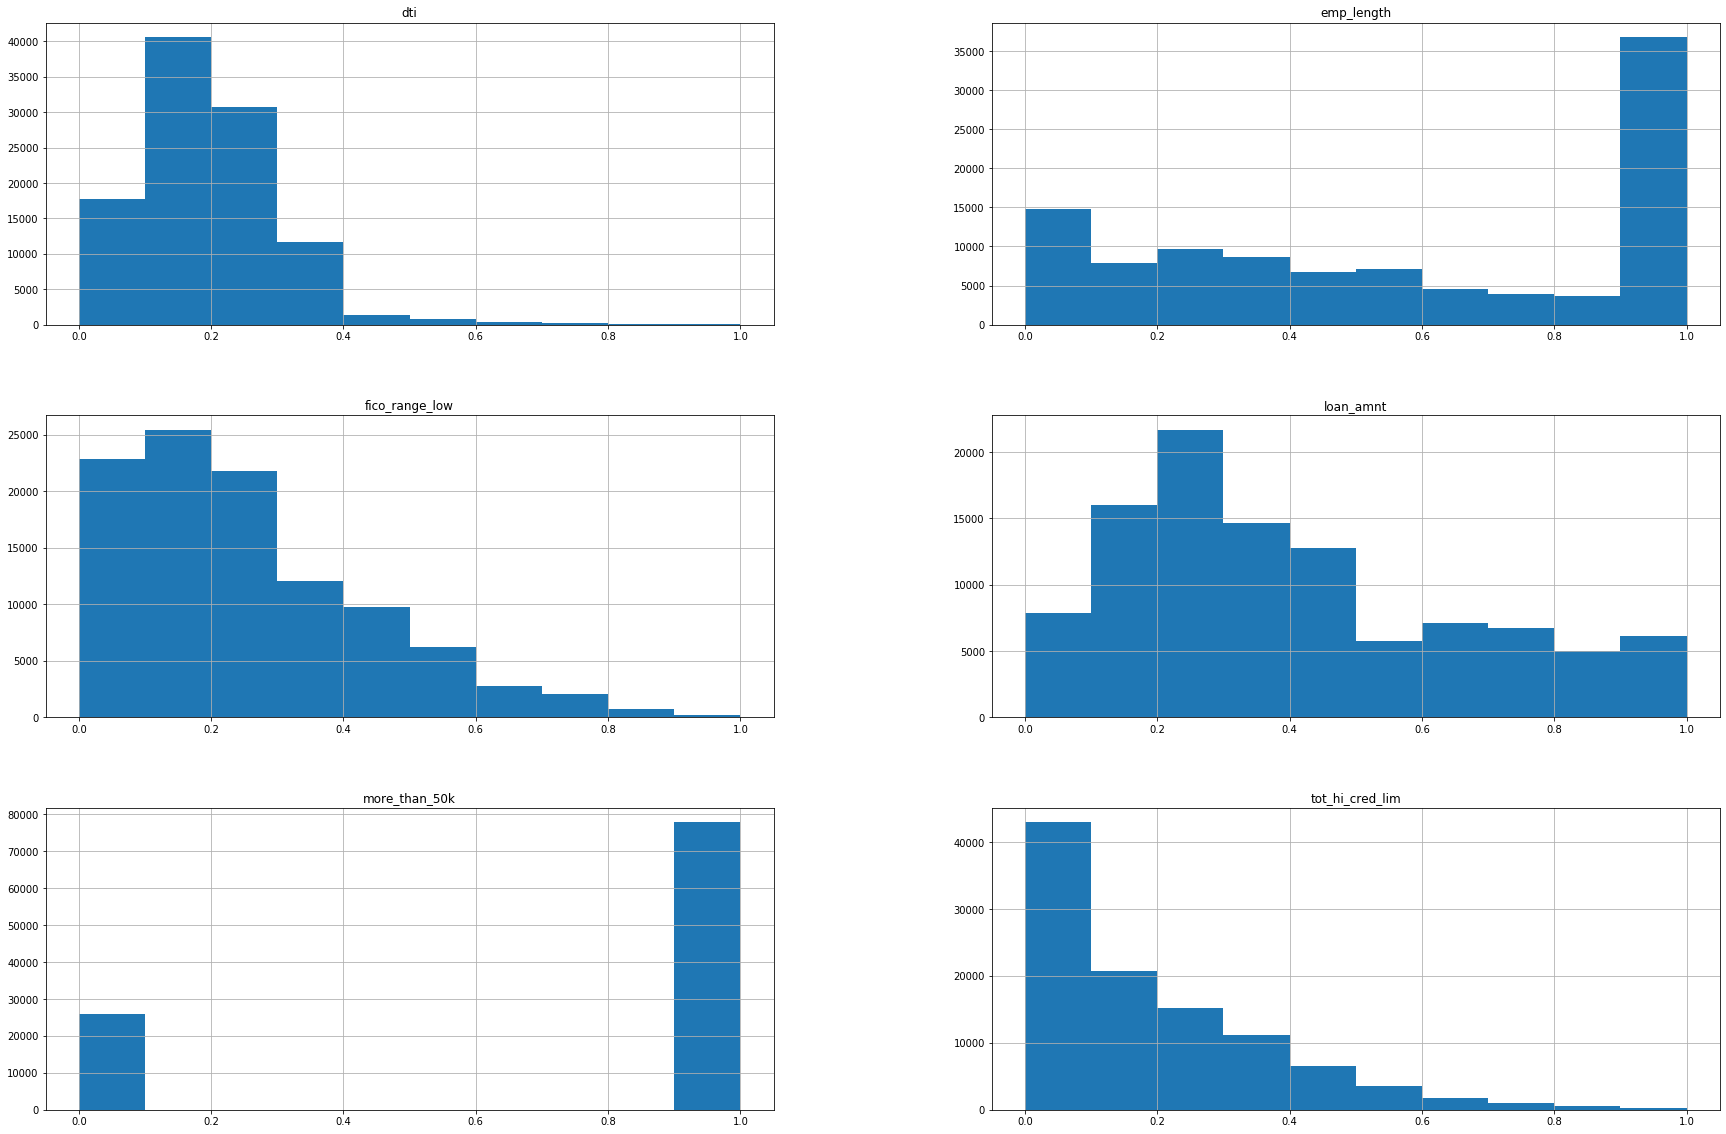

In [19]:
feat = df1.loc[:, 'more_than_50k':'dti']
feat.hist(figsize=(30,20));

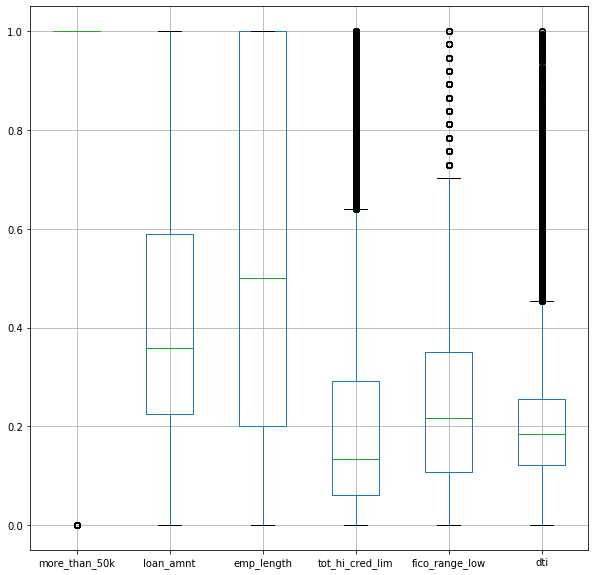

In [20]:
feat.boxplot(figsize=(10,10));

In [25]:
feat.isna().any().any()

False

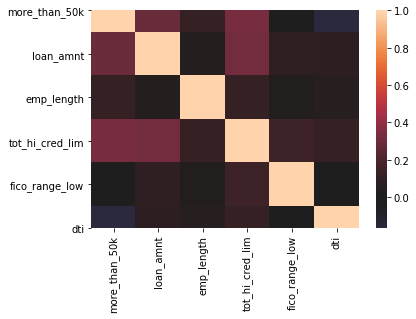

In [26]:
feat = df1.loc[:, 'more_than_50k':'dti']

sns.heatmap(feat.corr(), center=0)

In [27]:
# One-Hot Encoding Categorical Columns
df1 = pd.get_dummies(df1, drop_first=True)

In [28]:
df1.drop('id', axis=1, inplace=True)

In [29]:
df1

,annual_inc,more_than_50k,loan_amnt,emp_length,tot_hi_cred_lim,fico_range_low,dti,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,68000.0,1,0.320513,0.8,0.224949,0.486486,0.157605,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,110000.0,1,0.487179,1.0,0.256559,0.081081,0.234705,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27840.0,0,0.015385,0.1,0.047005,0.135135,0.160108,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,28000.0,0,0.138462,0.0,0.022706,0.216216,0.086312,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,130000.0,1,0.615385,0.0,0.348941,0.189189,0.233003,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115668,52500.0,1,0.358974,1.0,0.193513,0.189189,0.217683,0,1,0,...,0,0,0,0,0,0,0,0,0,0
115671,96000.0,1,0.128205,0.0,0.033508,0.432432,0.003104,0,1,0,...,0,0,0,0,0,0,0,0,0,0
115672,32000.0,0,0.384615,1.0,0.034208,0.135135,0.209172,0,1,0,...,0,0,0,0,0,0,0,0,0,0
115673,72000.0,1,0.384615,0.5,0.251547,0.000000,0.070291,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df1.describe()

,annual_inc,more_than_50k,loan_amnt,emp_length,tot_hi_cred_lim,fico_range_low,dti,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
count,1.037230e+05,103723.000000,103723.000000,103723.000000,103723.000000,103723.000000,103723.000000,103723.000000,103723.000000,103723.000000,...,103723.000000,103723.000000,103723.000000,103723.000000,103723.000000,103723.000000,103723.000000,103723.000000,103723.000000,103723.000000
mean,8.740465e+04,0.750412,0.408988,0.544410,0.196836,0.252399,0.196212,0.278087,0.550919,0.056593,...,0.001996,0.017219,0.083723,0.006864,0.027043,0.002372,0.021249,0.013343,0.005438,0.002005
std,1.089144e+05,0.432777,0.265250,0.386987,0.175734,0.186896,0.106936,0.448059,0.497403,0.231064,...,0.044629,0.130087,0.276973,0.082567,0.162210,0.048643,0.144214,0.114740,0.073539,0.044736
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.023100e+04,1.000000,0.225641,0.200000,0.060853,0.108108,0.122359,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.200000e+04,1.000000,0.358974,0.500000,0.133841,0.216216,0.183739,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.030000e+05,1.000000,0.589744,1.000000,0.292311,0.351351,0.255132,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


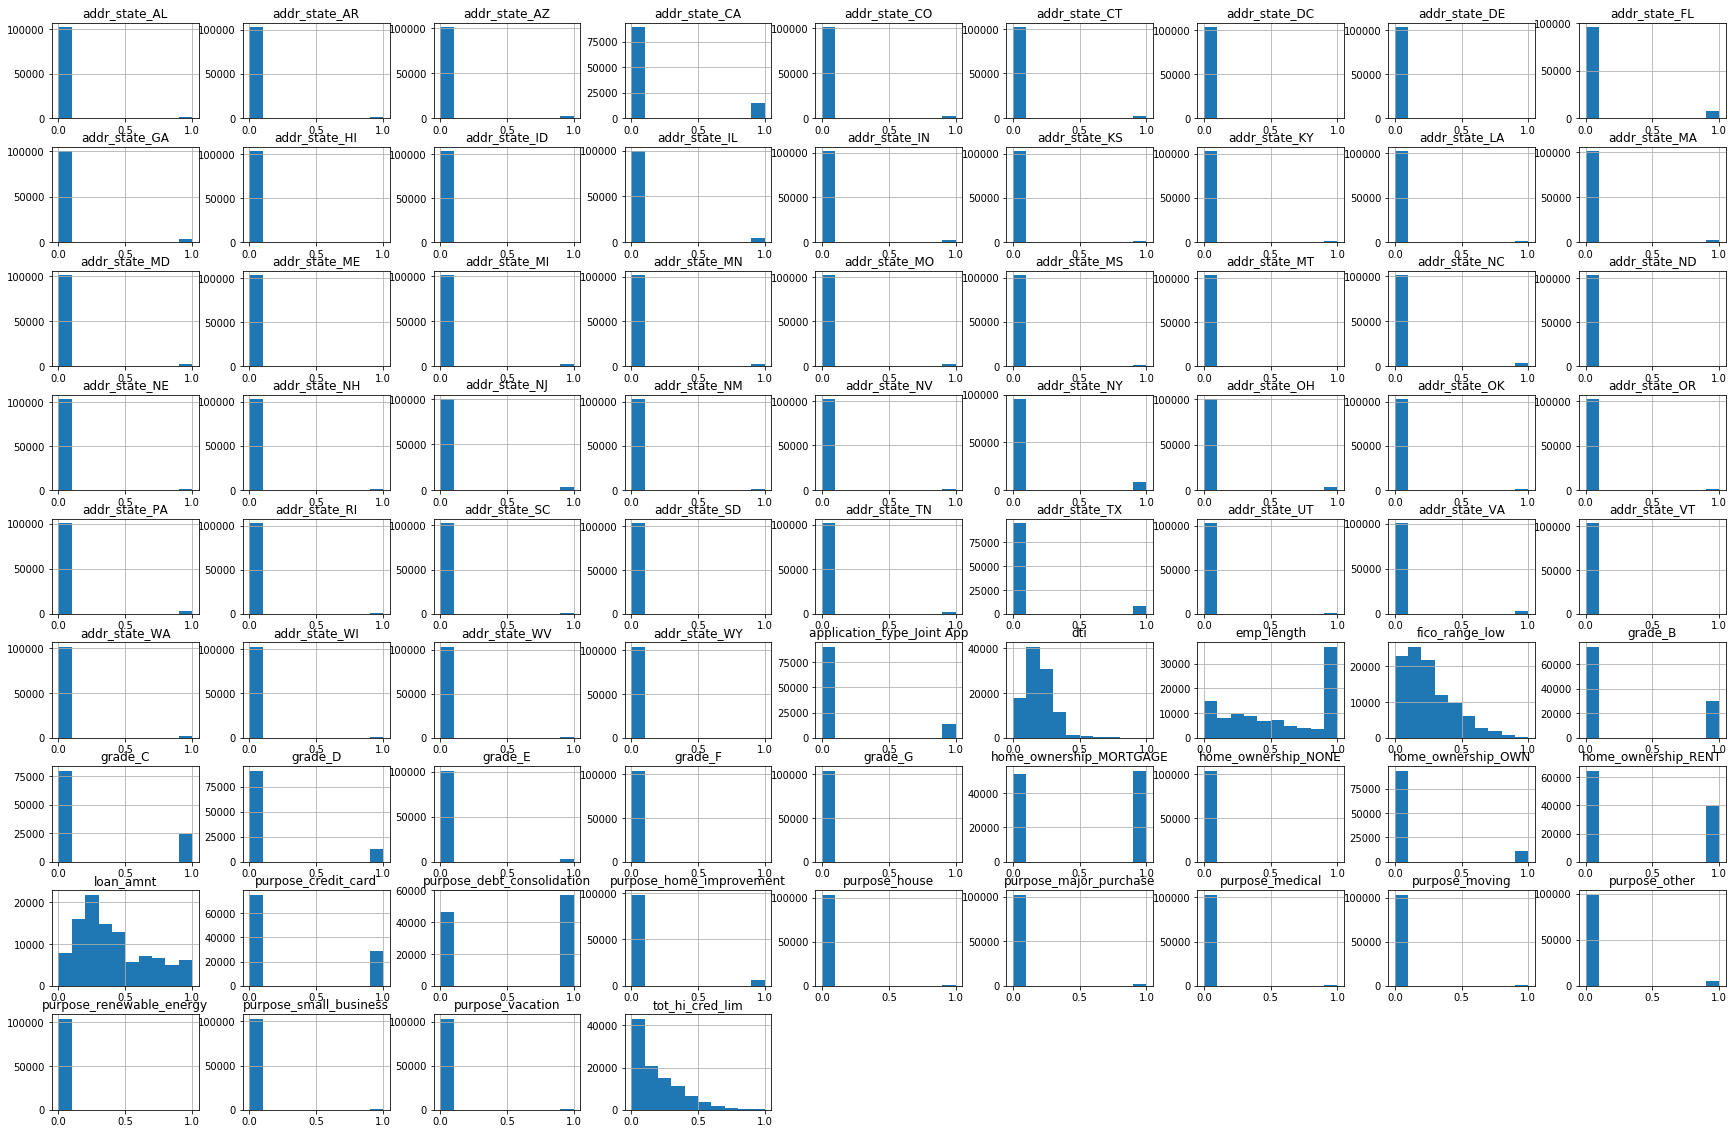

In [31]:
feat = df1.loc[:, 'loan_amnt':'addr_state_WY']
feat.hist(figsize=(30,20));

In [32]:
# feat

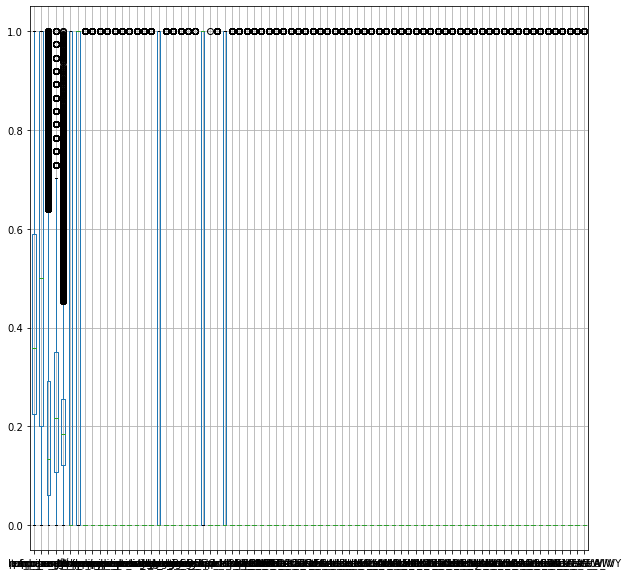

In [33]:
feat.boxplot(figsize=(10,10));

In [34]:
feat.isna().any().any()

False

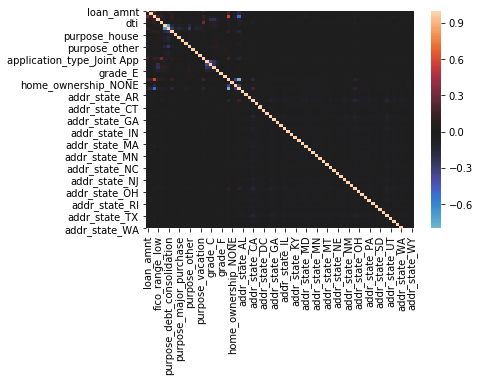

In [35]:
feat = df1.loc[:, 'loan_amnt':'addr_state_WY']

sns.heatmap(feat.corr(), center=0)

In [36]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=20)
pca_2 = PCA(n_components=30)
pca_3 = PCA(n_components=40)

principalComponents = pca_1.fit_transform(feat)
principalComponents = pca_2.fit_transform(feat)
principalComponents = pca_3.fit_transform(feat)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

pca = PCA(n_components=19)
principalComponents = pca.fit_transform(feat)
print(np.sum(pca.explained_variance_ratio_))

0.8118332775289819
0.8901655356208237
0.941565850202327
0.801555346900233


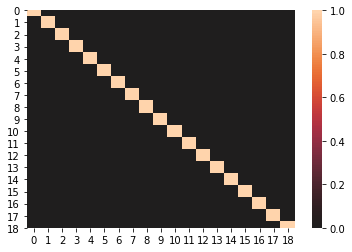

In [37]:
sns.heatmap(pd.DataFrame(principalComponents).corr(), center=0);

In [38]:
y = df1['more_than_50k']
X = df1.loc[:, 'loan_amnt':'addr_state_WY']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [40]:
pipe_lr = Pipeline([('pca', PCA(n_components=19, random_state=1)),
         ('clf', LogisticRegression(random_state=1))])

# Fit the pipelines
pipe_lr.fit(X_train, y_train)

print(pipe_lr.score(X_test, y_test))

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7725476018317667


In [41]:
np.sum(pipe_lr.predict(X_test) == y_test)/len(y_test)

0.7725476018317667

In [42]:
%%time
# Your code here
# ⏰ This cell may take several minutes to run
## KEEP IT FOR NOW
# Construct some pipelines
pipe_svm = Pipeline([('pca', PCA(n_components=19)),
        ('clf', svm.SVC(random_state=1))])
        
pipe_tree = Pipeline([('pca', PCA(n_components=19)),
        ('clf', tree.DecisionTreeClassifier(random_state=1))])

pipe_rf = Pipeline([('pca', PCA(n_components=19)),
        ('clf', RandomForestClassifier(random_state=1))])

# List of pipelines, List of pipeline names
pipelines = [pipe_svm, pipe_tree, pipe_rf]
pipeline_names = ['Support Vector Machine','Decision Tree','Random Forest']

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)

# Compare accuracies
for index, val in enumerate(pipelines):
    print(f"{pipeline_names[index]}'s pipeline test accuracy: {val.score(X_test, y_test):.3f}")

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=19,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=19,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=1,
                                        splitter='best'))],
         verbose=False)
Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n

/Users/kennymiyasato/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Support Vector Machine's pipeline test accuracy: 0.755
Decision Tree's pipeline test accuracy: 0.709
Random Forest's pipeline test accuracy: 0.752
CPU times: user 2min 51s, sys: 1.09 s, total: 2min 53s
Wall time: 2min 45s


### Random Forest pipeline with grid search

In [46]:
%%time
# Your code here
# ⏰ This cell may take a long time to run!
# Construct pipeline
pipe_rf = Pipeline([('pca', PCA(n_components=19)),
            ('clf', RandomForestClassifier(random_state = 1))])

# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': [120],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6],  
   'clf__min_samples_leaf':[0.05 ,0.1, 0.2],  
   'clf__min_samples_split':[0.05 ,0.1, 0.2]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=3, verbose=5, return_train_score = True, n_jobs=-1)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best accuracy
print(f"Best accuracy: {gs_rf.best_score_:.3f}")

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  1.7min finished


Best accuracy: 0.752

Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 120}
Wall time: 1min 52s


In [47]:
gs_rf.cv_results_

{'mean_fit_time': array([10.74700157, 10.95633539,  9.03166699,  7.49633376,  7.32918517,
         7.56218926,  4.22567828,  4.05700183,  4.36951931, 11.12785014,
        10.8245159 ,  8.35318573,  6.97466826,  7.48866789,  7.64133326,
         4.25133316,  3.93766522,  4.25499217, 10.67466418, 10.56366905,
         8.19833128,  6.78233306,  7.84647918,  7.65114284,  4.246605  ,
         3.87778044,  4.33984057,  8.09651319,  8.11414131,  6.67327968,
         5.70404387,  6.15641197,  6.33144768,  3.75438841,  3.80671072,
         4.0985961 ,  8.63960234,  8.42491078,  6.52477264,  5.89760788,
         6.26725499,  6.46680959,  3.89765724,  3.61287149,  4.03682574,
         8.51611066,  8.50904385,  6.69801037,  5.90080953,  6.40809226,
         6.39067817,  3.91723402,  3.68902588,  2.8897109 ]),
 'std_fit_time': array([0.10316534, 0.07391196, 0.03926393, 0.15416416, 0.15251347,
        0.06985536, 0.26605483, 0.28048475, 0.05604086, 0.24935291,
        0.16359988, 0.1078278 , 0.28210

### Adaboost

In [50]:
%%time
# Your code here
# ⏰ This cell may take several minutes to run
from sklearn.ensemble import AdaBoostClassifier
# Construct pipeline
pipe_ab = Pipeline([('pca', PCA(n_components=19)),
            ('clf', AdaBoostClassifier(random_state = 1))])

# Set grid search params
adaboost_param_grid = {
    'clf__n_estimators': [30, 50, 70],
    'clf__learning_rate': [1.0, 0.5, 0.1]
}

# Construct grid search
gs_ab = GridSearchCV(estimator=pipe_ab,
            param_grid=adaboost_param_grid,
            scoring='accuracy',
            cv=3, verbose=5, return_train_score = True, n_jobs=-1)

# Fit using grid search
gs_ab.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_ab.best_score_)

# Best params
print('\nBest params:\n', gs_ab.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  27 | elapsed:   12.6s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:   15.2s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed:   20.4s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   23.9s finished


Best accuracy: 0.773

Best params:
 {'clf__learning_rate': 1.0, 'clf__n_estimators': 70}
Wall time: 33.7 s


In [51]:
gs_ab.cv_results_

{'mean_fit_time': array([ 5.54904898,  8.75146572, 11.72170409,  5.52286545,  8.25683761,
        11.16317169,  5.05935701,  7.27385036,  8.25184997]),
 'std_fit_time': array([0.02262977, 0.02182314, 0.0526623 , 0.02833693, 0.06018107,
        0.02049961, 0.03596548, 0.07207291, 0.09657287]),
 'mean_score_time': array([0.15967004, 0.23866844, 0.31366571, 0.16966772, 0.25833424,
        0.29533331, 0.18266702, 0.19566941, 0.18366687]),
 'std_score_time': array([0.00524661, 0.00946237, 0.0033002 , 0.00169791, 0.0118966 ,
        0.00543622, 0.01247365, 0.00618145, 0.00169967]),
 'param_clf__learning_rate': masked_array(data=[1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_clf__n_estimators': masked_array(data=[30, 50, 70, 30, 50, 70, 30, 50, 70],
              mask=[False, False, False, False, False, False, False, False,
       

### SVM pipeline with grid search

In [35]:
%%time
# Your code here
# ⏰ This cell may take a very long time to run!
# Construct pipeline
pipe_svm = Pipeline([('pca', PCA(n_components=19)),
            ('clf', svm.SVC(random_state=1))])

# Set grid search params
param_grid_svm = [
  {'clf__C': [0.1, 1, 10]  , 'clf__kernel': ['linear']},
  {'clf__C': [1, 10], 'clf__gamma': [0.001, 0.01], 'clf__kernel': ['rbf']},
 ]

# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='accuracy',
            cv=3, verbose=10, return_train_score = True, n_jobs=-1)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_svm.best_score_)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  21 | elapsed:  2.8min remaining: 12.0min
[Parallel(n_jobs=-1)]: Done   7 out of  21 | elapsed:  3.2min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done  10 out of  21 | elapsed:  3.2min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  13 out of  21 | elapsed:  5.6min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:  5.6min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  19 out of  21 | elapsed:  5.7min remaining:   36.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  5.8min finished


Best accuracy: 0.753

Best params:
 {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Wall time: 7min 35s


In [36]:
gs_svm.cv_results_

{'mean_fit_time': array([102.10688623,  98.06221771, 120.862885  , 122.09588178,
        121.51952664, 116.13369544, 109.9734935 ]),
 'std_fit_time': array([2.00701112, 2.56391657, 2.03038917, 1.80531568, 1.8018207 ,
        1.48095161, 2.88868145]),
 'mean_score_time': array([21.78666647, 21.86199959, 23.78900258, 23.27333347, 16.58382789,
        16.98464672, 16.36552167]),
 'std_score_time': array([0.0422403 , 0.13441931, 0.19284515, 0.09948018, 0.07803166,
        0.09945531, 0.02980437]),
 'param_clf__C': masked_array(data=[0.1, 1, 10, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__kernel': masked_array(data=['linear', 'linear', 'linear', 'rbf', 'rbf', 'rbf',
                    'rbf'],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__gamma': masked_array(data=[--, --, --, 0.001, 0.01, 0.001, 0.

In [68]:
# More than 50k Count
# print('Target Variable')
# print(df1.groupby(['more_than_50k']).more_than_50k.count())

# Target Variable Countplot
# sns.set_style('darkgrid')
# plt.figure(figsize = (10,5))
# sns.countplot(df1['more_than_50k'], alpha =.80, palette= ['grey','lightgreen'])
# plt.title('More than 50k vs Less than 50k')
# plt.ylabel('# of Applicants')
# plt.show()

In [26]:
# beat 33% from looking at the base accuracy rate

In [ ]:
feat = df1.loc[:, 'more_than_50k':'dti']
feat.hist(figsize=(30,20));

In [27]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scratch Work

In [45]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# df.head()
# df.columns
# cols = df.columns.tolist()

# df.drop(df.columns[0], axis=1)
# new_header = df.iloc[0] #grab the first row for the header
# df = df[1:] #take the data less the header row
# df.columns = new_header #set the header row as the df header

# df1['addr_state'].unique()
# df1['home_ownership'].unique()
# df1['grade'].unique()
# df1['application_type'].unique()
# df1['purpose'].unique()

# df1['loan_amnt'].equals(df1['funded_amnt'])

# df1.isna().sum()

# y = df1[['more_than_50k']]
# X = df1.drop(['id', 'annual_inc', 'more_than_50k', 'purpose',
#      'application_type', 'grade', 'home_ownership', 'addr_state'], axis=1)

# cred_lim = 1000000
# df1[df1['tot_hi_cred_lim'] >= cred_lim].sort_values('tot_hi_cred_lim', ascending=False)

# (df1[df1['tot_hi_cred_lim'] >= cred_lim].sort_values('tot_hi_cred_lim', ascending=False)).count()

# df1.info()

# df1.isna().any()

# feats = ['addr_state', 'home_ownership', 'grade']
# df1 = df1[feats]
 
# df1 = df[['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d']]
df1 = df[['loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state','dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record']]
# df1 = df[['open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d']]
# df1 = df[['last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code']]
# df1 = df[['application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m']]
# df1 = df[['open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m']]
# df1 = df[['max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal']]
# df1 = df[['bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl']]
# df1 = df[['mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl']]
# df1 = df[['num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m']]
# df1 = df[['num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim']]
# df1 = df[['total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths']]
# df1 = df[['sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog']]
# df1 = df[['hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date']]
# df1 = df[['payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag']]
# df1  = df[['debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term']]
df1.head(20)
# df1[df1['dti'] > 80].sort_values('dti', ascending=True)

,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record
0,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,152xx,PA,15.74,0.0,Mar-2010,750.0,754.0,0.0,NaN,NaN
1,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,100xx,NY,23.44,0.0,Sep-2003,675.0,679.0,0.0,39.0,NaN
2,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,other,Other,787xx,TX,15.99,0.0,Nov-2011,685.0,689.0,1.0,NaN,NaN
3,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,109xx,NY,8.62,0.0,Jan-2010,700.0,704.0,0.0,49.0,NaN
4,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,704xx,LA,23.27,0.0,Apr-2006,695.0,699.0,0.0,72.0,NaN
5,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,077xx,NJ,29.58,0.0,Jul-2007,680.0,684.0,0.0,47.0,NaN
6,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,402xx,KY,21.51,0.0,Jan-2000,695.0,699.0,2.0,37.0,NaN
7,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,958xx,CA,14.02,0.0,Sep-2006,695.0,699.0,1.0,50.0,NaN
8,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,600xx,IL,8.16,0.0,Oct-1995,770.0,774.0,0.0,NaN,NaN
9,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,152xx,PA,13.47,0.0,Apr-1993,700.0,704.0,0.0,38.0,NaN


In [345]:
# df1.isna().sum()

In [346]:
# df1 = df1.dropna()

In [347]:
# len(df1['emp_title'].unique())

In [348]:
# df1['application_type'].unique()

In [204]:
X = df1#.drop('income', 1)
for col_name in X.columns:
    if X[col_name].dtypes == 'object':
        unique_cat = len(X[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'purpose' has 12 unique categories
Feature 'application_type' has 2 unique categories
Feature 'grade' has 7 unique categories
Feature 'home_ownership' has 5 unique categories
Feature 'addr_state' has 50 unique categories


In [243]:
# print(X['addr_state'].value_counts().sort_values(ascending=False).head(55))

In [231]:
# df2 = df1.groupby('application_type')
# df2 = df1.sort_values(by=['application_type'])
# df2.tail(50)

# Notes

In [59]:
# .*\n.*\n

# id = A unique LC assigned ID for the loan listing.
# member_id = no use / A unique LC assigned Id for the borrower member.
# loan_amnt = The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
# funded_amnt = The total amount committed to that loan at that point in time.
# funded_amnt_inv = The total amount committed by investors for that loan at that point in time.
# term = The number of payments on the loan. Values are in months and can be either 36 or 60.
# int_rate = 
# grade = LC assigned loan grade
# sub_grade = LC assigned loan subgrade
# emp_length = Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
# home_ownership = The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
# ****annual_inc = The self-reported annual income provided by the borrower during registration.
# addr_state = The state provided by the borrower in the loan application
# dti = A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
# fico_range_low = The lower boundary range the borrower’s FICO at loan origination belongs to.
# fico_range_high = The upper boundary range the borrower’s FICO at loan origination belongs to.


# useful columns
# id
# loan_amnt
# funded_amnt
# grade
# sub_grade
# emp_length
# home_ownership
# ****annual_inc
# addr_state 
# fico_range_low
# dti



# no dti > 100
# 115274
# 104294
# 10,980‬

# 115677
# 104544
# 11,133‬

# DB Stuff

In [50]:
state = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR',
         'California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE',
         'District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI',
         'Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA',
         'Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME',
         'Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
         'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE',
         'Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM',
         'New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH',
         'Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI',
         'South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX',
         'Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA',
         'West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}

median_income = "DP03_0062E"

def get_list_of_tuples_from_api_census(variable_name, year):
    parameters = {
        "get": f"NAME,{variable_name}",
        "for": "state:*",
        "key": config.census_api_key
    }

    response = requests.get(f"http://api.census.gov/data/{year}/acs/acs1/profile", params=parameters)

    json_response = response.json()

    df = pd.DataFrame(json_response)
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index()
    df = df.drop(['index'], axis=1)
    df['abbrev'] = df['NAME'].map(state)
    df['year']=year
    df['PK']=df['abbrev']+df['year'].map(str)
    df = df[['NAME', 'abbrev', 'DP03_0062E', 'year', 'PK']].sort_values(by=['abbrev'])

    list_of_tuples = []
    for index, row in df.iterrows():
        list_of_tuples.append((row['NAME'], row['abbrev'], row[f'{variable_name}'], row['year'], row['PK']))
        
    return list_of_tuples


'admin'

In [53]:
state = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR',
         'California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE',
         'District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI',
         'Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA',
         'Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME',
         'Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
         'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE',
         'Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM',
         'New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH',
         'Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI',
         'South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX',
         'Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA',
         'West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}

median_income = "DP03_0062E"

def get_list_of_tuples_from_api_census(variable_name, year):
    parameters = {
        "get": f"NAME,{variable_name}",
        "for": "state:*",
        "key": config.census_api_key
    }

    response = requests.get(f"http://api.census.gov/data/{year}/acs/acs1/profile", params=parameters)

    json_response = response.json()

    df = pd.DataFrame(json_response)
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index()
    df = df.drop(['index'], axis=1)
    df['abbrev'] = df['NAME'].map(state)
    df['year']=year
    df['PK']=df['abbrev']+df['year'].map(str)
    df = df[['NAME', 'abbrev', 'DP03_0062E', 'year', 'PK']].sort_values(by=['abbrev'])

    list_of_tuples = []
    for index, row in df.iterrows():
        list_of_tuples.append((row['NAME'], row['abbrev'], row[f'{variable_name}'], row['year'], row['PK']))
        
    return list_of_tuples


In [54]:
years = [*range(2010,2019)]

census_median_income_data = []
for year in years:
    census_median_income_data.append(get_list_of_tuples_from_api_census(median_income, year))

In [55]:
census_median_income_data

[[('Alaska', 'AK', '64576', 2010, 'AK2010'),
  ('Alabama', 'AL', '40474', 2010, 'AL2010'),
  ('Arkansas', 'AR', '38307', 2010, 'AR2010'),
  ('Arizona', 'AZ', '46789', 2010, 'AZ2010'),
  ('California', 'CA', '57708', 2010, 'CA2010'),
  ('Colorado', 'CO', '54046', 2010, 'CO2010'),
  ('Connecticut', 'CT', '64032', 2010, 'CT2010'),
  ('District of Columbia', 'DC', '60903', 2010, 'DC2010'),
  ('Delaware', 'DE', '55847', 2010, 'DE2010'),
  ('Florida', 'FL', '44409', 2010, 'FL2010'),
  ('Georgia', 'GA', '46430', 2010, 'GA2010'),
  ('Hawaii', 'HI', '63030', 2010, 'HI2010'),
  ('Iowa', 'IA', '47961', 2010, 'IA2010'),
  ('Idaho', 'ID', '43490', 2010, 'ID2010'),
  ('Illinois', 'IL', '52972', 2010, 'IL2010'),
  ('Indiana', 'IN', '44613', 2010, 'IN2010'),
  ('Kansas', 'KS', '48257', 2010, 'KS2010'),
  ('Kentucky', 'KY', '40062', 2010, 'KY2010'),
  ('Louisiana', 'LA', '42505', 2010, 'LA2010'),
  ('Massachusetts', 'MA', '62072', 2010, 'MA2010'),
  ('Maryland', 'MD', '68854', 2010, 'MD2010'),
  ('Main

In [146]:
state = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR',
         'California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE',
         'District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI',
         'Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA',
         'Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME',
         'Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
         'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE',
         'Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM',
         'New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH',
         'Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI',
         'South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX',
         'Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA',
         'West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}

state_code = {  '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR',
                '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE',
                '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI',
                '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA',
                '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME',
                '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN',
                '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE',
                '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM',
                '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH',
                '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI',
                '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX',
                '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA',
                '54': 'WV', '55': 'WI', '56': 'WY', '72': 'PR'}


variable_name = "DP03_0062E"
parameters = {
    "get": f"NAME,{variable_name}",
    "for": "county:*",
    "in" : "state:*",
    "key": config.census_api_key
}

response = requests.get(f"http://api.census.gov/data/2017/acs/acs5/profile", params=parameters)

json_response = response.json()

df = pd.DataFrame(json_response)
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index()
df = df.drop(['index'], axis=1)
df['abbr'] = df['state'].map(state_code)
df = df[['NAME','abbr','state','DP03_0062E','county']]


In [147]:
df

,NAME,abbr,state,DP03_0062E,county
0,"Pickens County, Alabama",AL,01,36220,107
1,"Sumter County, Alabama",AL,01,21663,119
2,"Jefferson County, Alabama",AL,01,49321,073
3,"Choctaw County, Alabama",AL,01,32122,023
4,"Franklin County, Alabama",AL,01,39501,059
5,"Monroe County, Alabama",AL,01,26036,099
6,"DeKalb County, Alabama",AL,01,38842,049
7,"Escambia County, Alabama",AL,01,35026,053
8,"Lamar County, Alabama",AL,01,36016,075
9,"Randolph County, Alabama",AL,01,39485,111


In [121]:
# df = df.replace(to_replace=[', Alabama'], value =[''])

# df['NAME'] = df['NAME'].str.replace(', Alabama','')

In [122]:
for state_name in state:
    df['NAME'] = df['NAME'].str.replace(f', {state_name}','')
#     df['NAME'] = df['NAME'].str.replace('County','')
#     df['NAME'] = df['NAME'].str.replace('Municipio','')

In [123]:
df

,NAME,DP03_0062E,state,county
0,Pickens County,36220,AL,107
1,Sumter County,21663,AL,119
2,Jefferson County,49321,AL,073
3,Choctaw County,32122,AL,023
4,Franklin County,39501,AL,059
5,Monroe County,26036,AL,099
6,DeKalb County,38842,AL,049
7,Escambia County,35026,AL,053
8,Lamar County,36016,AL,075
9,Randolph County,39485,AL,111


In [ ]:
df1 = df1.replace(to_replace=["< 1 year", "10+ years"], value=["0", "10"])
df1['emp_length'] = df1['emp_length'].str.replace('years','')
df1['emp_length'] = df1['emp_length'].str.replace('year','')
df1['emp_length'] = pd.to_numeric(df1['emp_length'])
